<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2025/blob/main/Homeworks/HW02_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети в биоинформатике

### Домашнее задание 2. Сверточные нейронные сети.

### О задании

В этом задании вам предстоит в продолжение семинара 2 (BloodMNIST) поработать с датасетом RetinaMnist. Для того, чтобы понять, как его скачать, обратитесь к [документации](https://github.com/MedMNIST/MedMNIST).

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'retinamnist'
download = True

#Получение информации о датасете
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) #normalized = (pixel_value - 0.5) / 0.5
])

#Загрузка данных
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
train_dataset

100%|██████████| 3.29M/3.29M [00:00<00:00, 4.90MB/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz


Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 1080
    Root location: /root/.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0

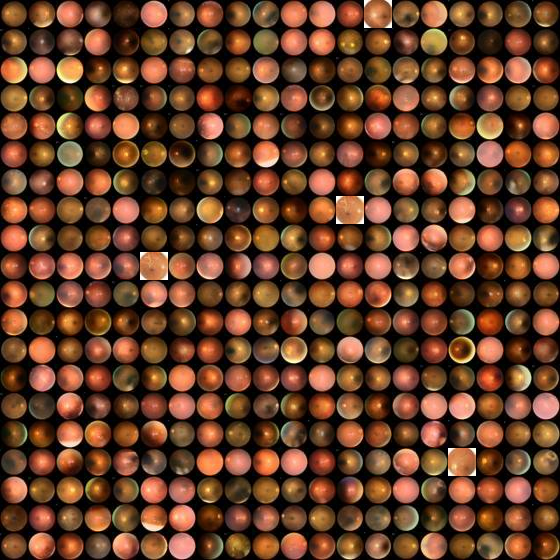

In [ ]:
train_dataset.montage(length=20)

Аналогично семинару постройте CNN с небольшим числом слоев (например, 4).

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            #16 фильтров размером 3x3.
            #size = 28x28x32

            nn.BatchNorm2d(32),

            nn.ReLU(),

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Расчет размерностей:
            #P = 0 - заполнение
            #matrix_size = (( width - kernel_size + 2 * P ) / stride ) + 1
            #Уменьшает пространственные размеры карт признаков вдвое, снижая вычислительную нагрузку и делая сеть более устойчивой к небольшим изменениям во входных данных.
            #size = 14x14x32

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            #size = 14x14x16
            nn.BatchNorm2d(16),

            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = floor((width - kernel_size) / stride) + 1 = floor((14 - 2) / 2) + 1 = 7
            #size = 7x7x16
            nn.Flatten(),

            #Полносвязный слой. 32 входа 7x7 после Flatten = 16 * 7 * 7 = 784
            nn.Linear(784, 128),

            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = Net(in_channels=n_channels, num_classes=n_classes)

#Устанавливаем Loss функцию и оптимизатор для обучения
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Подготовка данных с использование Batch:

In [ ]:
BATCH_SIZE = 64
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Обучение:

In [ ]:
train_losses = []
for epoch in range(4):
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)

        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 17/17 [00:01<00:00, 15.59it/s]


Тестирование:

In [ ]:
test_losses = []
for epoch in range(4):
    model.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


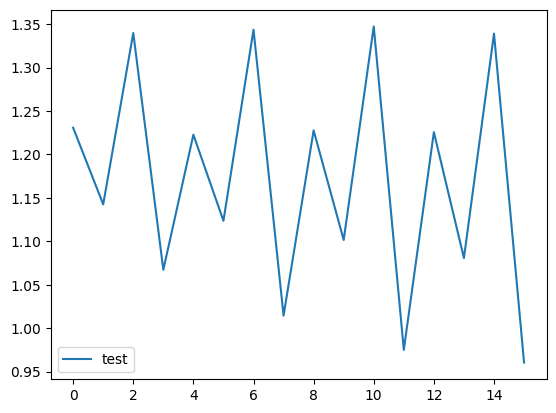

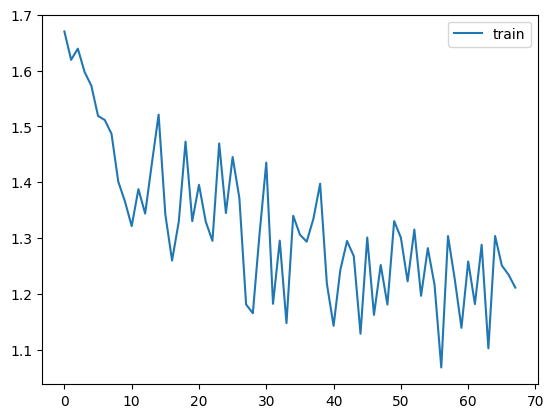

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

Странно, но в принципе падает, возможно стоит просто понизить lr

In [ ]:
def test():
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

==> Evaluating ...
test  auc: 0.812  acc:0.350



Пооптимизируйте архитектуру вашей нейронной сети:

1. Добавьте больше CNN-блоков.

2. Попробуйте использовать GlobalAveragePooling.

3. Всегда ли увеличение числа сверточных слоев в сети улучшает ее качество? Помогает ли справиться с данной проблемой BatchNorm2D?

Ответ на основе кода ниже: Нет, Да

1. Увеличение слоев + удаление BatchNorm + повыщение lr

In [ ]:
class Net2WithoutBatchNorm(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net2WithoutBatchNorm, self).__init__()
        self.model = nn.Sequential(
            #Dataset RetinaMNIST of size 28 (retinamnist)

            #1 Frame----------------------------------------------------------
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            #16 фильтров размером 3x3.
            #size = 28x28x32

            nn.ReLU(),
            #1 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = ((width - kernel_size) / stride) + 1 = ((28 - 2) / 2) + 1 = 14
            #size = 14x14x32

            #2 Frame----------------------------------------------------------
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            #size = 14x14x16

            nn.ReLU(),
            #2 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = ((width - kernel_size) / stride) + 1 = ((14 - 2) / 2) + 1 = 7
            #size = 7x7x16

            #3 Frame----------------------------------------------------------
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            #size = 7x7x8

            nn.ReLU(),
            #3 Frame----------------------------------------------------------

            nn.Flatten(),

            #Полносвязный слой. После Flatten = 8 * 7 * 7 = 392
            nn.Linear(392, 128),
            nn.ReLU(),

            #Полносвязный слой (Выходной слой)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model2WithoutBatchNorm = Net2WithoutBatchNorm(in_channels=n_channels, num_classes=n_classes)

Обучение:

In [ ]:
optimizer = optim.SGD(model2WithoutBatchNorm.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses = []
for epoch in range(4):
    model2WithoutBatchNorm.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model2WithoutBatchNorm(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Тестирование:

In [ ]:
test_losses = []
for epoch in range(4):
    model2WithoutBatchNorm.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = model2WithoutBatchNorm(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


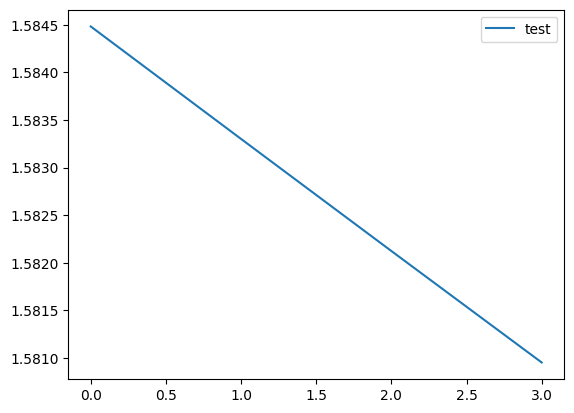

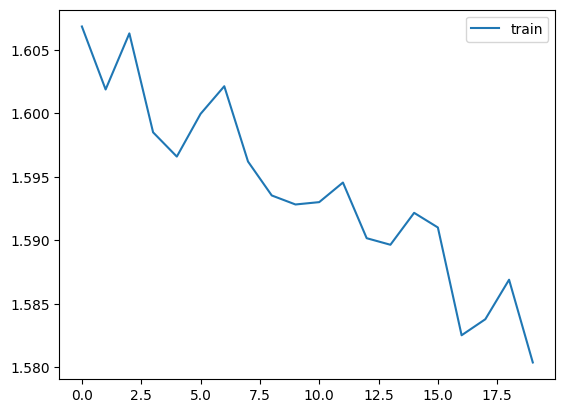

==> Evaluating ...
test  auc: 0.586  acc:0.435


In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    model2WithoutBatchNorm.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model2WithoutBatchNorm(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Добавление еще одного сверточного слоя и лишения BatchNorm привело к ухудшению падения loss (было 0,01, стало 0,008). Accuracy тоже упал, что не хорошо.

2. Добавление BatchNorm:

In [ ]:
class Net2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net2, self).__init__()
        self.model = nn.Sequential(
            #Dataset RetinaMNIST of size 28 (retinamnist)

            #1 Frame----------------------------------------------------------
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            #16 фильтров размером 3x3.
            #size = 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #1 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = ((width - kernel_size) / stride) + 1 = ((28 - 2) / 2) + 1 = 14
            #size = 14x14x32

            #2 Frame----------------------------------------------------------
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            #size = 14x14x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #2 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = ((width - kernel_size) / stride) + 1 = ((14 - 2) / 2) + 1 = 7
            #size = 7x7x16

            #3 Frame----------------------------------------------------------
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            #size = 7x7x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #3 Frame----------------------------------------------------------

            nn.Flatten(),

            #Полносвязный слой. После Flatten = 8 * 7 * 7 = 392
            nn.Linear(392, 128),
            nn.ReLU(),

            #Полносвязный слой (Выходной слой)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model3 = Net2(in_channels=n_channels, num_classes=n_classes)

Обучение:

In [ ]:
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)
train_losses = []
for epoch in range(4):
    model3.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model3(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Тестирование:

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


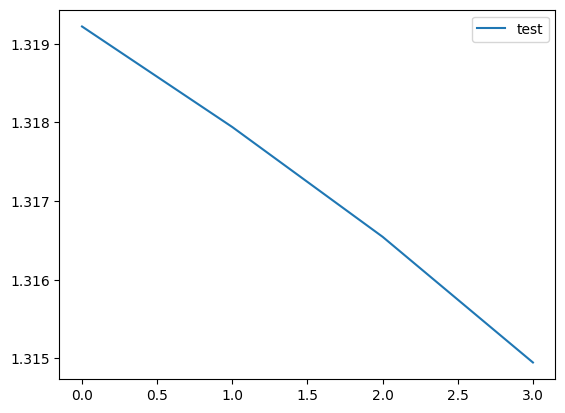

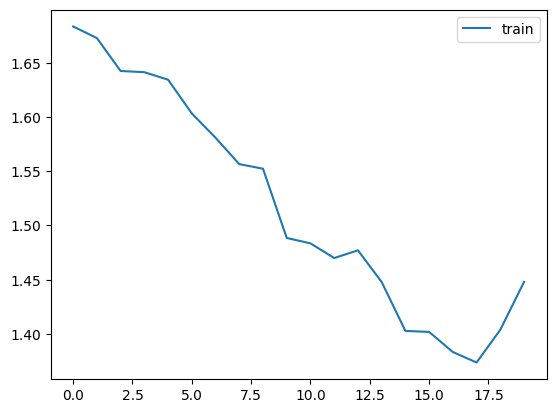

==> Evaluating ...
test  auc: 0.679  acc:0.435


In [ ]:
test_losses = []
for epoch in range(4):
    model3.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = model3(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    model3.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model3(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

В целом ситуация стала немного лучше

3. Добавление GlobalAveragePooling + подберем lr

In [ ]:
class Net3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net3, self).__init__()
        self.model = nn.Sequential(
            #Dataset RetinaMNIST of size 28 (retinamnist)

            #1 Frame----------------------------------------------------------
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            #16 фильтров размером 3x3.
            #size = 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #1 Frame----------------------------------------------------------

            nn.AdaptiveAvgPool2d((14, 14)), #!!! Метод автоматически подбирает параметры надо только указать желаемы размер выходной матрицы
            #size = 14x14x32

            #2 Frame----------------------------------------------------------
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            #size = 14x14x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #2 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #matrix_size = ((width - kernel_size) / stride) + 1 = ((14 - 2) / 2) + 1 = 7
            #size = 7x7x16

            #3 Frame----------------------------------------------------------
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            #size = 7x7x8
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #3 Frame----------------------------------------------------------

            nn.Flatten(),

            #Полносвязный слой. После Flatten = 8 * 7 * 7 = 392
            nn.Linear(392, 128),
            nn.ReLU(),

            #Полносвязный слой (Выходной слой)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model4 = Net3(in_channels=n_channels, num_classes=n_classes)

Обучение:

In [ ]:
optimizer = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)

train_losses = []
for epoch in range(4):
    model4.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model4(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Тестирование:

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


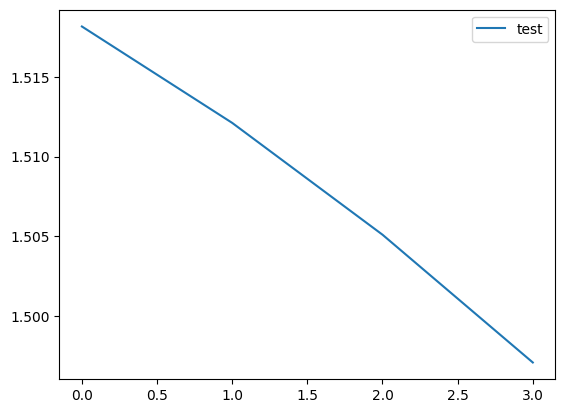

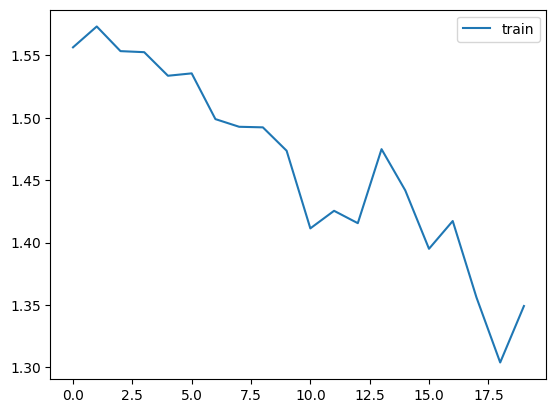

==> Evaluating ...
test  auc: 0.656  acc:0.435


In [ ]:
test_losses = []
for epoch in range(4):
    model4.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = model4(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    model4.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model4(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Статистика еще немного ухудшилась, в данном случаи я использовал AdaptiveAvgPool2d вместо MaxPooling после первого сверточного слоя.

В итоге, наилучшая модель это предыдущая.

Теперь попробуем подобрать lr, которая обеспечит лучшую статистику модели 2.

In [ ]:
modelFinal = Net2(in_channels=n_channels, num_classes=n_classes)

optimizer = optim.SGD(modelFinal.parameters(), lr=0.004, momentum=0.9)

train_losses = []
for epoch in range(4):
    modelFinal.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = modelFinal(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


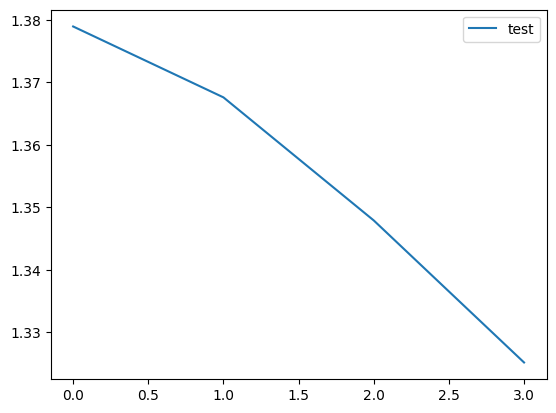

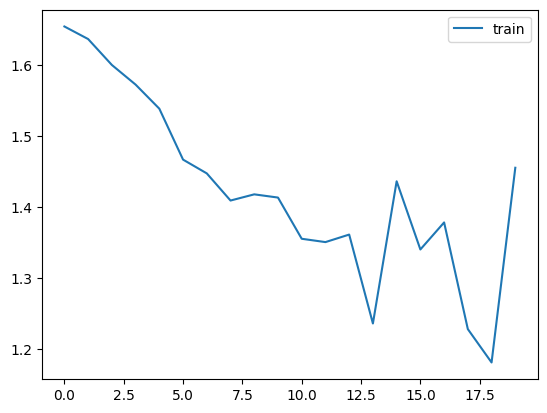

==> Evaluating ...
test  auc: 0.684  acc:0.435


In [ ]:
test_losses = []
for epoch in range(4):
    modelFinal.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = modelFinal(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    modelFinal.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = modelFinal(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Резульаты не очень удовлетворительны, при сильном повышении lr возрастает Accuracy, функция loss становиться более хаотичной, тоже самое наблюдаетя и при занижении lr, картина походая. Так что опимальное lr отсается 0.001

4. Все же удалим один сверточный слой (в итоге мы просто вернулись к первой версии):

In [ ]:
class NetW(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(NetW, self).__init__()
        self.model = nn.Sequential(
            #1 Frame----------------------------------------------------------
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            #16 фильтров размером 3x3.
            #size = 28x28x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
             #1 Frame----------------------------------------------------------

            #Макс-пулинг
            nn.MaxPool2d(kernel_size=2, stride=2),
            #size = 14x14x32

            #2 Frame----------------------------------------------------------
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            #size = 14x14x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #2 Frame----------------------------------------------------------

            nn.MaxPool2d(kernel_size=2, stride=2),
            #size = 7x7x16
            nn.Flatten(),

            #Полносвязный слой. 32 входа 7x7 после Flatten = 16 * 7 * 7 = 784
            nn.Linear(784, 128),

            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

modelW = NetW(in_channels=n_channels, num_classes=n_classes)

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


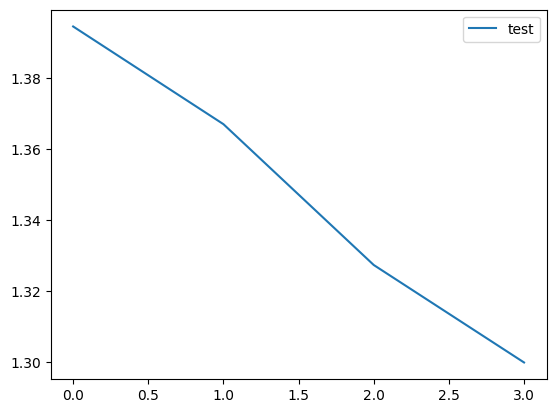

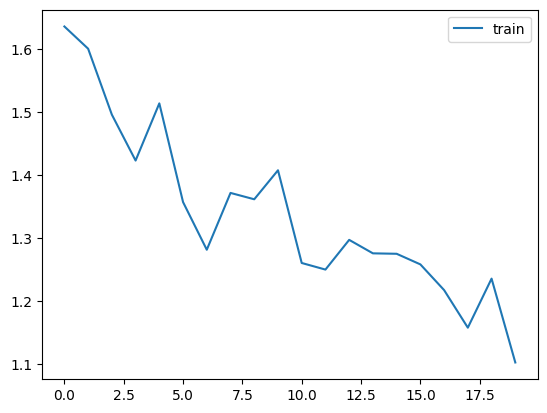

==> Evaluating ...
test  auc: 0.707  acc:0.435


In [ ]:
optimizer = optim.SGD(modelW.parameters(), lr=0.004, momentum=0.9)
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

train_losses = []
for epoch in range(4):
    modelW.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = modelW(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

test_losses = []
for epoch in range(4):
    modelW.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = modelW(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    modelW.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = modelW(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Попробуйте применить оптимизированную архитектуру к задаче, разобранной на семинаре 2 (BloodMnist). Улучшилось ли качество и на этом датасете?

Для теста будем использовать начальную версию и наилучшую версию с 3 свертками:

1. Наилучшая с 3 слоями

Загруим данные:

In [ ]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

BATCH_SIZE = 124
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 35.5M/35.5M [00:25<00:00, 1.41MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


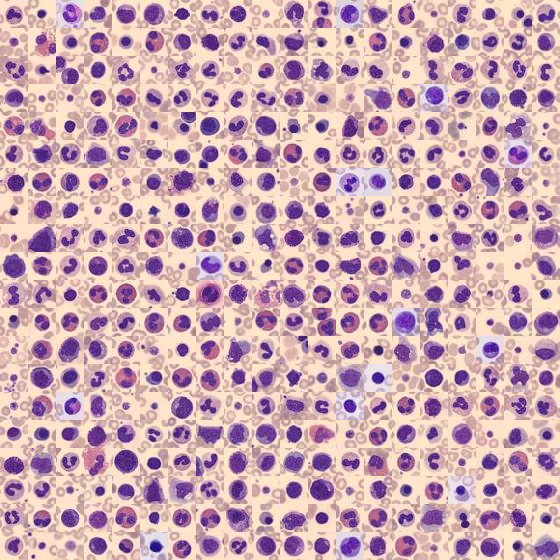

In [ ]:
train_dataset.montage(length=20)

Обучение:

In [ ]:
modelFinal = Net2(in_channels=n_channels, num_classes=n_classes)
optimizer = optim.SGD(modelFinal.parameters(), lr=0.001, momentum=0.9)

train_losses = []
for epoch in range(4):
    modelFinal.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = modelFinal(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

100%|██████████| 97/97 [00:15<00:00,  6.35it/s]


Тестирование:

100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


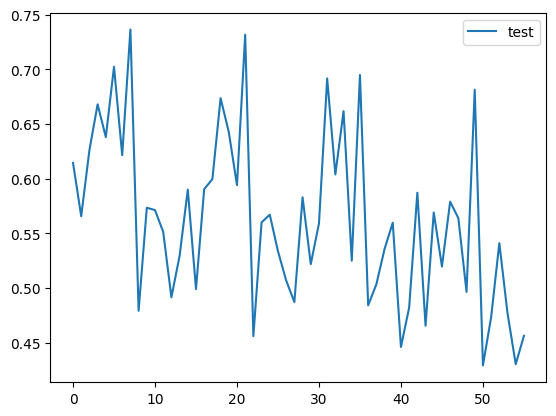

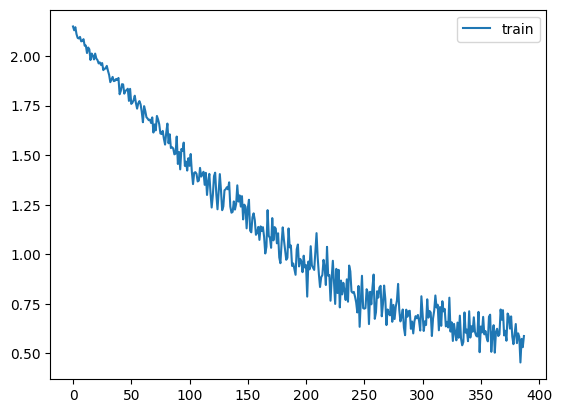

==> Evaluating ...
test  auc: 0.972  acc:0.811


In [ ]:
import matplotlib.pyplot as plt

test_losses = []
for epoch in range(4):
    modelFinal.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = modelFinal(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    modelFinal.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = modelFinal(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Данные модели с семинара:

==> Evaluating ...

train  auc: 0.975  acc:0.822

test  auc: 0.972  acc:0.814

2. Первая версия:

100%|██████████| 14/14 [00:02<00:00,  5.86it/s]


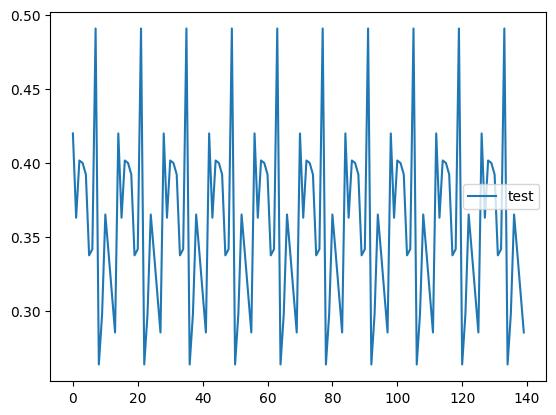

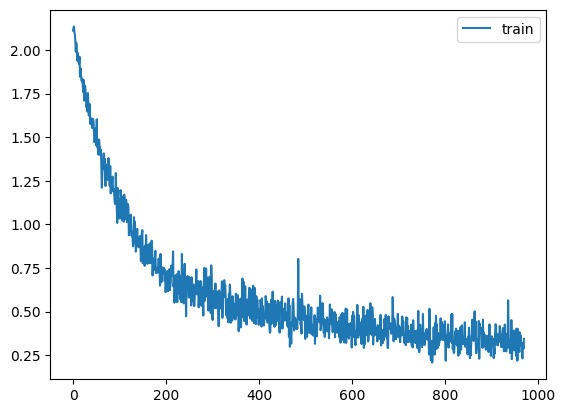

==> Evaluating ...
test  auc: 0.986  acc:0.880


In [ ]:
#Обучение
modelStart = Net(in_channels=n_channels, num_classes=n_classes)
optimizer = optim.SGD(modelStart.parameters(), lr=0.001, momentum=0.9)

train_losses = []
for epoch in range(10):
    modelStart.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = modelStart(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        train_losses.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()

#Тестирование
import matplotlib.pyplot as plt

test_losses = []
for epoch in range(10):
    modelStart.eval()
    for inputs, targets in tqdm(test_loader):
        optimizer.zero_grad()
        outputs = modelStart(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)
        test_losses.append(loss.detach().numpy())

plt.plot(test_losses, label="test")
plt.legend()
plt.show()

plt.plot(train_losses, label="train")
plt.legend()
plt.show()

def test():
    modelStart.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = modelStart(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

Данные модели с семинара:

==> Evaluating ...

train auc: 0.975 acc:0.822

test auc: 0.972 acc:0.814

Accuracy стало немного лучше, но здесь такие же проблемы как и на предыдущей на test хоть и в целом низкие loss, но он ведут себя очень нестабильно, врядли является хорошм знаком.

Так же есть шум на test. И судя по нему модель в принципе плохо обучается на этом датасете.

One Cycle LR

**************************************************************************

In [ ]:
max_lr = 1e-2
div_factor = 25
min_lr = max_lr / div_factor
device = torch.device("cpu")
model = Net(in_channels=n_channels, num_classes=n_classes)
model = model.to(device)

#Устанавливаем Loss функцию и оптимизатор для обучения
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

### Количество эпох и значение коэффициента скорости обучения можно менять!
NUM_EPOCHS = 3
lr = 0.1

optimizer = optim.AdamW(model.parameters(), lr=min_lr)

batch_per_epoch = len(train_loader)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                        max_lr=max_lr,
                       steps_per_epoch=batch_per_epoch,
                       epochs=NUM_EPOCHS,
                       pct_start=0.3,#default
                       three_phase=False,
                       div_factor=div_factor)

In [ ]:
for epoch in range(3):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            outputs = outputs.softmax(dim=-1)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()
        scheduler.step()

100%|██████████| 97/97 [00:14<00:00,  6.75it/s]


In [ ]:
def test():
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, 'test')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % ('test', *metrics))
#Запуск
print('==> Evaluating ...')
test()

==> Evaluating ...
test  auc: 0.865  acc:0.733


In [ ]:
def test_split(model, split):
    model.eval()
    test_losses = []

    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            loss = criterion(outputs, targets)
            test_losses.append(loss.detach().numpy())

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test_split(model, 'train')
test_split(model, 'test')

==> Evaluating ...
train  auc: 0.870  acc:0.741
test  auc: 0.865  acc:0.733


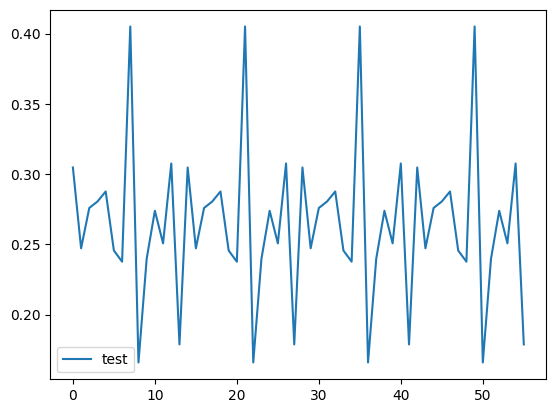

In [ ]:
plt.plot(test_losses, label="test")
plt.legend()
plt.show()